## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [167]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [168]:
# Readign the file
df = pd.read_csv('ab_data.csv')
# Taking a look at our dataset
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [169]:
# Getting the number of rows in the dataset
df.shape[0]

294478

c. The number of unique users in the dataset.

In [170]:
# Getting the number of unique users
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [171]:
# Getting the proportion of converted users
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [172]:
# Calculating rows where treatment and control doesn't line up with old an new pages
df.query('(group == "treatment") != (landing_page == "new_page")')['user_id'].count()

3893

f. Do any of the rows have missing values?

In [173]:
# Checking for missing values
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [174]:
# Creating a new dataframe where control and treatment doesn't line up with old and new page
df2 = df.query("(group == 'control' & landing_page == 'old_page') or (group == 'treatment' & landing_page == 'new_page')")

In [175]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [176]:
# Getting the number of unique user ids
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [177]:
# Getting the duplicated user id
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [178]:
# Getting the rows of the duplicated user id
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [179]:
# Dropping one of the duplicate id
df2 = df2.drop_duplicates(['user_id'])
# Looking at how many rows after dropping
df2.shape[0]

290584

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [180]:
# Getting the probability of converting
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [181]:
# Getting the probability of control group converting
df2.query("group == 'control'")['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [182]:
# Getting the probabilty of control group converting
df2.query("group == 'treatment'")['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [184]:
# Getting the probabilty of receiving new page
df2.query("landing_page == 'new_page'")['user_id'].count() / df2['user_id'].count()

0.50006194422266881

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

**There is no strong evidence that the new page lead to more conversions, We can see that the control group(the old page) converted a rate of approximately 12.0%  which is slightly higher than the treatment group(the new page) that have a converted rate of approximately 11.9%, the diffrence is only around 0.1%, In order to provide meaningful information we need to calculate p-values and do hypothesis test for the new and old page.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

- **(The Null Hypothesis)**  **$H_{0}$** : **$p_{old}$**  ≥  **$p_{new}$**
- **(The Alternative Hypothesis)** **$H_{1}$** : **$p_{new}$** ≥ **$p_{old}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [185]:
# Getting the convert rate for P_new under the null
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [186]:
# Getting the convert rate for P_new under the null
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [187]:
# Calculating the number of users who has the new page
n_new = df2.query("landing_page == 'new_page'")['user_id'].count()
n_new

145310

d. What is $n_{old}$?

In [188]:
# Calculating the number of users who has the old page
n_old = df2.query("landing_page == 'old_page'")['user_id'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [189]:
# Simulating N_new transactions with aa convert of P_new under the null
new_page_converted = np.random.binomial(n_new, p_new)
new_page_converted

17406

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [190]:
# Simulating N_old transactions with aa convert of P_old under the null
old_page_converted = np.random.binomial(n_old, p_old)
old_page_converted

17426

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [191]:
# Calculating P_new - P_old and getting the diffrence
new_page_converted/n_new - old_page_converted/n_old

-0.0001673545873220883

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [192]:
# Creating a sampling distribution 
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(n_new, p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    diffs = new_page_converted/n_new - old_page_converted/n_old
    p_diffs.append(diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

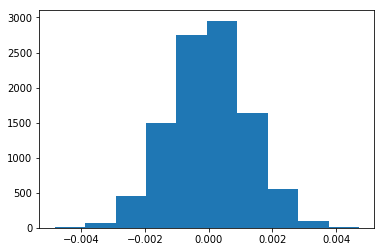

In [193]:
# Plotting a histogram
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [194]:
# Calculating the actuall diffrence and printing it
actual_diffs = df2.query("group == 'treatment'")['converted'].mean() - df2.query("group == 'control'")['converted'].mean()
print(actual_diffs)

# Getting the p_value
(actual_diffs < p_diffs).mean()

-0.00157823898536


0.90200000000000002

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The value above is called the p-value, The p-value is the probability of observing our statistic or a more extreme statistic if the null hypothesis is true, As the p-value is large enough we would fail to reject the null hypothesis, In our case we have a p-value of 0.908 which gives us evidence that the null hypothesis is true And telling us to keep the old page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [195]:
# Importing required libraries
import statsmodels.api as sm

#Calculating the conversions
convert_old = df2.query("landing_page == 'old_page' & converted == 1")['user_id'].count()
convert_new = df2.query("landing_page == 'new_page' & converted == 1")['user_id'].count()
n_old = df2.query("landing_page == 'old_page'")['user_id'].count()
n_new = df2.query("landing_page == 'new_page'")['user_id'].count()
# Printing the values
print(convert_old, convert_new, n_old, n_new)

17489 17264 145274 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [196]:
# Getting the z_score and the p_value
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
# Printing the values
print(z_score, p_value)

1.31092419842 0.905058312759


In [197]:
# importing required library
from scipy.stats import norm
# Getting how significant our z-score
print(norm.cdf(z_score))
# Getting the critical score in a 95% confidence rate
print(norm.ppf(1-(0.05)))

0.905058312759
1.64485362695


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**I calculated the z_score and the p_value and the z_score gave me a score of approximately 1.31 and a p_value of approximately 0.90, Also we calculated the critical value which is 1.644, Since the z_score (1.31) is less than the critical score(1.644) We fail to reject the null hypothesis And agree with the findings in part j And k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [198]:
# Creating a column for the intercept
df2['intercept'] = 1
# Creating dummy variables
df2[['control', 'treatment']] = pd.get_dummies(df2['group'])
# Taking a look at the dummy variables
df2.head(3)

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [199]:
# Creating a logistoc regression model
logit = sm.Logit(df2['converted'], df2[['intercept', 'treatment']])
# Fitting the model
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [200]:
# Getting the summary
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 27 Jul 2018   Pseudo R-squ.:               8.077e-06
Time:                        13:28:53   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment     -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?

**The p_value associated with ab_page is 0.190, The diffrence in part II That this is a one sided test and the last one was a two sided test.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Yes, It is a good idea to consider other factor to add, As other factors may result in more accurate tests and informations, However, there is some disadvatages to adding additional terms into our regression model, One of them is called (Multicollinearity) which lead to unreliable estimated of regression coefficents.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [201]:
# Reading the countries file
country_df = pd.read_csv('./countries.csv')
# Creating a new data frame and joining them with the previous data frame
df3 = country_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [202]:
# Creating the dummy variables
df3[['UK', 'US']] = pd.get_dummies(df3['country'])[['UK', 'US']]

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [203]:
# Creating another logistic regression model
logit2 = sm.Logit(df3['converted'], df3[['UK', 'US']])
# Fitting the model
result2 = logit2.fit()
# Getting the summary
result2.summary()

Optimization terminated successfully.
         Current function value: 0.382864
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 27 Jul 2018   Pseudo R-squ.:                -0.04573
Time:                        13:29:01   Log-Likelihood:            -1.1125e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
UK            -1.9868      0.011   -174.174      0.000      -2.009      -1.964
US            -1.9967      0.007   -292.314      0.000      -2.010      -1.983
==============================================================================
"""

### Summary results:
**Looking at the summary above there is no evidence that shows the effect of conversions based on the country**

## Conclusion:

**In the end there is no reason to convert to the new page as there no evidence shows that the new page is better, in matter of fact the new page is doing worse than the old page, so in that case we fail to reject the null hypothesis and reject the alternative hypothesis**

In [204]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0